# Large Scale Single Cell Electrophysiology & Behavior

In [1]:
# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    print('allensdk already installed.')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


In [2]:
# Import necessary packages 
import numpy as np 
import pandas as pd 
import scipy as sp
import seaborn as sns
from scipy import signal
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine

# Import packages necessary to plot behavior
import allensdk.brain_observatory.ecephys.visualization as ecvis
from allensdk.brain_observatory.visualization import plot_running_speed

# Assign where neuropixels data and 2-photon data will be stored
manifest_path = 'manifest.json' 


# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))          

# Download our session data 
session = cache.get_session_data(721123822)

# Return units dataframe with specified snr and isi
units_df = session.units
good_snr = units_df[units_df['snr']>2]
good_units_df = good_snr[good_snr['isi_violations']<0.1]




print('Session downloaded.')

Session downloaded.


## Firing Rate 

In our dataframe, the mean spike rates for each unit can be found under the `firing_rate` column. Let, look at the distibution of firing rates across all brain areas using a violinplot. 

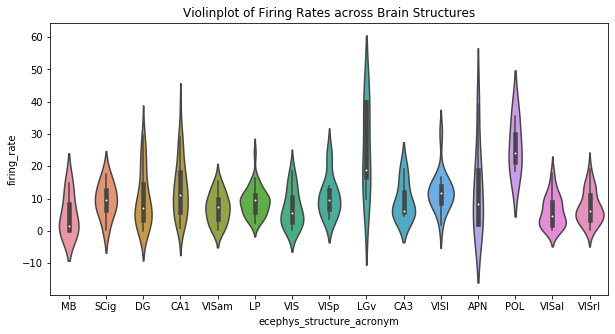

In [3]:
plt.figure(figsize = (10,5))
sns.violinplot(y='firing_rate', x='ecephys_structure_acronym',data = good_units_df)
plt.title('Violinplot of Firing Rates across Brain Structures')
plt.show()

## Spike Times

Our `EcephysSession` object contains spike times for each unit and they can be accessed via the `spike_times` attribute. This returns a dictionary where the `unit_id` of the neural units in our session are mapped to a list of spike times.  With this data, we are able to compare `spike_times` across units and across stimuli by plotting a rasterplot. 

We first need to select a unit to focus on. For the purposes of this notebook we will work units that were taken from the primary visual area (`VISp`). Below, we will assign the spike times of a unit from the `VISp` area. 

In [4]:
# Assign the spike times
all_spike_times = session.spike_times

# Assign a list of unit ids for units in VISp brain area
VISp_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'VISp'].index.values

# Assign spike times of first VISp entry 
first_VISp_units_id = VISp_unit_ids[0]
first_VISp_spike_times = all_spike_times[first_VISp_units_id]

# Return length of spike times and values for for VISp entry 
print('Spikes found for unit ' + str(first_VISp_units_id) + ': ' + str(len(all_spike_times[first_VISp_units_id])))

print(first_VISp_spike_times)

Spikes found for unit 950908410: 215133
[5.51623094e-01 6.20356427e-01 7.80456428e-01 ... 9.81109249e+03
 9.81112212e+03 9.81115902e+03]


With these spike times, we are able to create a raster plot for our unit of interst. Below we will plot out the first 50 seconds of the session. 

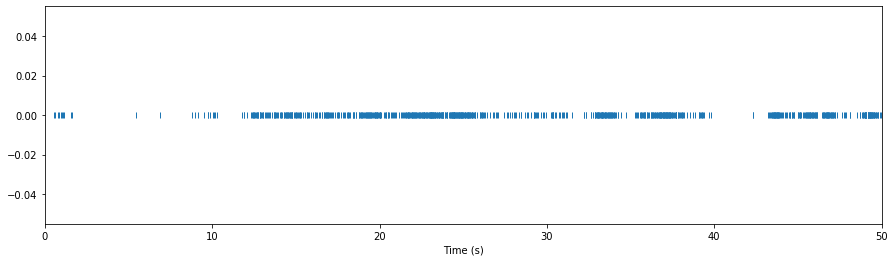

In [5]:
plt.figure(figsize=(15,4))
plt.plot(first_VISp_spike_times, np.repeat(0,len(first_VISp_spike_times)), '|')
plt.xlim(0,50)
plt.xlabel('Time (s)')
plt.show()

A raster plot maybe difficult to see the overall firing activity of a unit becasue there are too man spikes. Instead of looking at each individual spike across time, we can bin our spikes into 1 second bins and plot the spike frequency of each bin. 

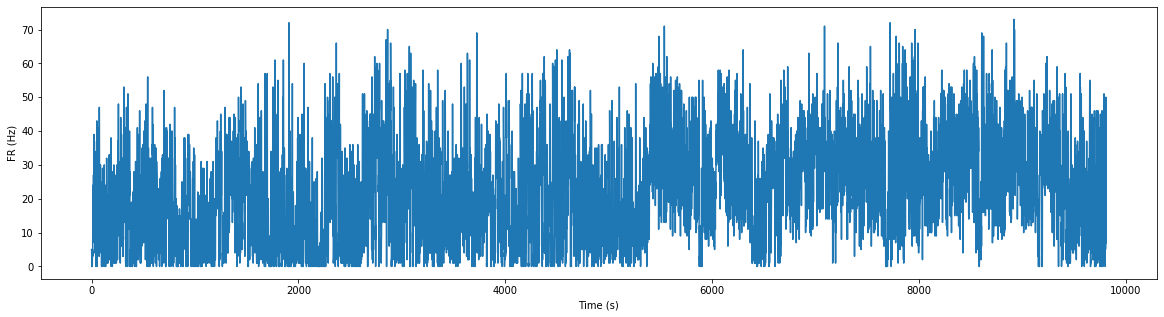

In [6]:
# Assign total number of bins 
numbins = int(np.ceil(first_VISp_spike_times.max()))
binned_spikes = np.empty((numbins))

# Assign the frequency of spikes over time
for i in range(numbins):
    binned_spikes[i] = len(first_VISp_spike_times[(first_VISp_spike_times>i)&(first_VISp_spike_times<i+1)])
    

plt.figure(figsize=(20,5))
plt.plot(binned_spikes)
plt.xlabel('Time (s)')
plt.ylabel('FR (Hz)')
plt.show()

The plot above is only for one unit in our session. We can also compare spike times across multiple units by plotting their spike times over each other. 

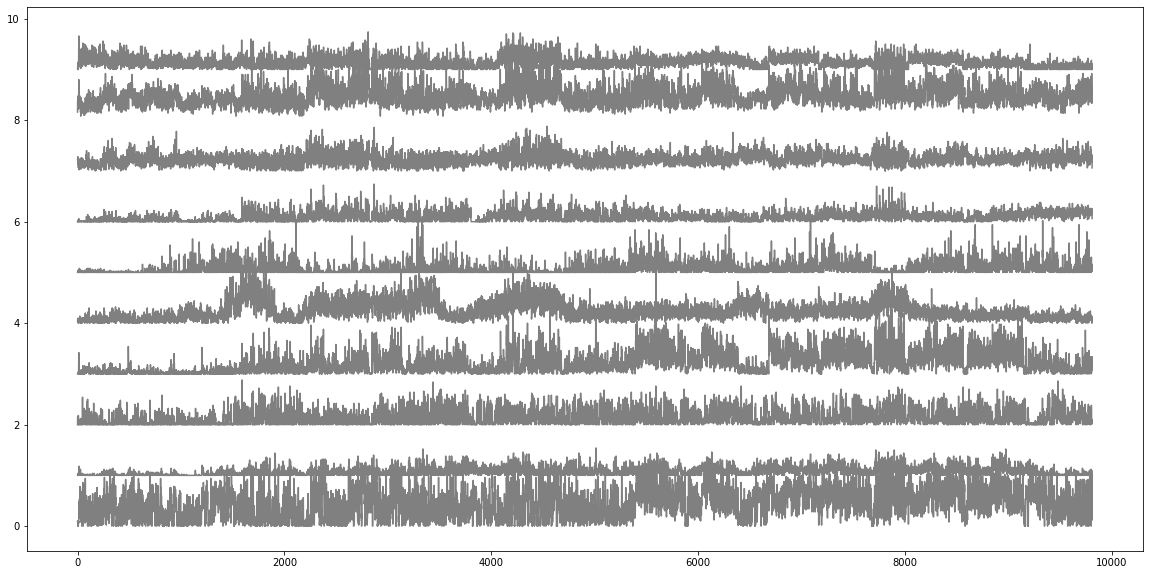

In [7]:
# Plot first 10 VISp entries spike times
numunits = 10
visp_binned = np.empty((numunits, numbins))

for i in range(numunits):
    unit_id = VISp_unit_ids[i]
    spikes = all_spike_times[unit_id]
    for j in range(numbins):
        visp_binned[i,j] = len(spikes[(spikes>j)&(spikes<j+1)])
        
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(visp_binned[i,:]/50), color='gray')

## Stimulus Presentations

The spike data can be sorted according to the type of stimulus that was presented to the mouse. You can access the different stimuli that were presented in the session by using the attribute `stimulus_names`. 

In [8]:
# Stimuli presented in session
all_stims = session.stimulus_names
all_stims

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

Each stimulus contains a set of parameters that were used when presented to the mouse. For example two gabors stimuli may be presented, but they may have differing temporal frequencies or different x and y positions. Ececuting the `stimulus_presentations` method on our session object will return a pandas dataframe with parameters for each stimulus as the columns which we can use to compare the resoponses of units to different stimulus presentations. 

**Note**: Not all stimuli share the same parameters. If certain parameters do not apply to a stimulus, you will see a `null` value. 

In [9]:
# Stimulus presentation dataframe 
stim_pres = session.stimulus_presentations
stim_pres.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,26.219072,null,spontaneous,86.285852,null,null,null,60.066780,0
1,null,0.8,null,45.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.285852,0.0,gabors,86.519369,4.0,-10.0,-20.0,0.233517,1
2,null,0.8,null,45.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.519369,0.0,gabors,86.769565,4.0,-40.0,-30.0,0.250196,2
3,null,0.8,null,90.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.769565,0.0,gabors,87.019762,4.0,-10.0,-10.0,0.250196,3
4,null,0.8,null,0.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,87.019762,0.0,gabors,87.269958,4.0,20.0,-10.0,0.250196,4


Each stimulus used in the session is presented to the mouse in various timeblocks. Using the `get_stimulus_epochs()` method will return a pandas dataframe containing the time periods where a single stimulus type was presented continuously. 

In [10]:
# Continous timeblocks where only 1 type of stimulus was presented
# Could maybe use this w/ running speed
stim_timeblocks = session.get_stimulus_epochs()
stim_timeblocks.head()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,26.219072,86.285852,60.066780,spontaneous,null
1,86.285852,998.280652,911.994800,gabors,0.0
2,998.280652,1287.272022,288.991370,spontaneous,null
3,1287.272022,1585.771259,298.499237,flashes,1.0
4,1585.771259,1587.522722,1.751463,spontaneous,null


The timeblocks above allow us to compare neural activity of the units when a new stimulus is being presented. By using `plt.axvspan` we can divide our current plot to show when one stimulus ends and a new one begins. Plotting this over the firing rates of our units will reveal what `stimulus_name` elicited the highest neural activity. 

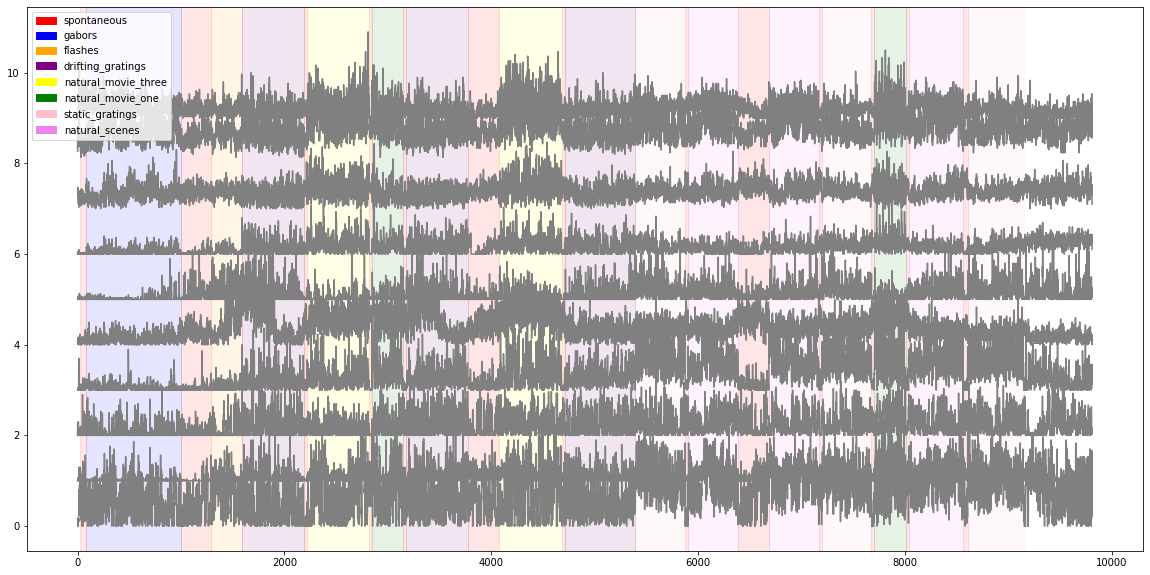

In [11]:
plt.figure(figsize=(20,10))

# Plots firing rates 
for i in range(numunits):
    plt.plot(i+(visp_binned[i,:]/30.), color='gray')

# Plots rectangle blocks that indicate new stimulus presentation 
colors = ['red','blue','orange','purple', 'yellow', 'green', 'pink', 'violet']
for c, stim_name in enumerate(all_stims):
    stim = stim_timeblocks[stim_timeblocks['stimulus_name']==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim['start_time'].iloc[j], xmax=stim['stop_time'].iloc[j], color=colors[c], alpha=0.1)

# Legend showing stimulus timeblocks
colors_leg = []
for i in range(len(colors)):
    temp_color = mpatches.Patch(color = colors[i], label = (all_stims[i]))
    colors_leg.append(temp_color)  
plt.legend(handles = colors_leg)

plt.show()

Alternatively, you could use the `get_stimulus_table()` method to return a subset of stimulus presentation by `stimulus_name`. The returned dataframe will only contain parameters that relate to the given `stimulus_name`. Below we will investigate how our neuronal units responded to a `natural_scenes` stimulus presentations.

In [12]:
natural_scenes_df = session.get_stimulus_table(['natural_scenes'])
natural_scenes_df.head()

,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51353,92.0,5905.128132,9.0,natural_scenes,5905.378346,0.250214,4908
51354,114.0,5905.378346,9.0,natural_scenes,5905.628560,0.250214,4909
51355,114.0,5905.628560,9.0,natural_scenes,5905.878774,0.250214,4909
51356,0.0,5905.878774,9.0,natural_scenes,5906.128988,0.250214,4910
51357,37.0,5906.128988,9.0,natural_scenes,5906.379197,0.250208,4911


We can look even further and check how the parameters of a stimulus affected the firing rate. In `natural_scenes` presentations, different frame/image was presented to the mouse. Below we will focus on the times that the first `frame` in our dataframe above, was presented in the session. 

In [13]:
# Assign indices of dataframe
natural_scenes_ids = natural_scenes_df.index

# Assign first 'natural_scenes' image presented in the session
my_image = natural_scenes_df.loc[natural_scenes_ids[1], 'frame']

# Return the number of times this image was presented
print('Number of times frame ' + str(my_image)+ ' was presented in the session:')
print(len(natural_scenes_df[natural_scenes_df['frame']==my_image]))

Number of times frame 114.0 was presented in the session:
50


As you can see from the dataframe above, the `natural_scenes` presentations also cotain start and end times. We can do what we did before and use `plt.axvspan()` to plot the times when the images of interest was presented over the firing rates of our session. 

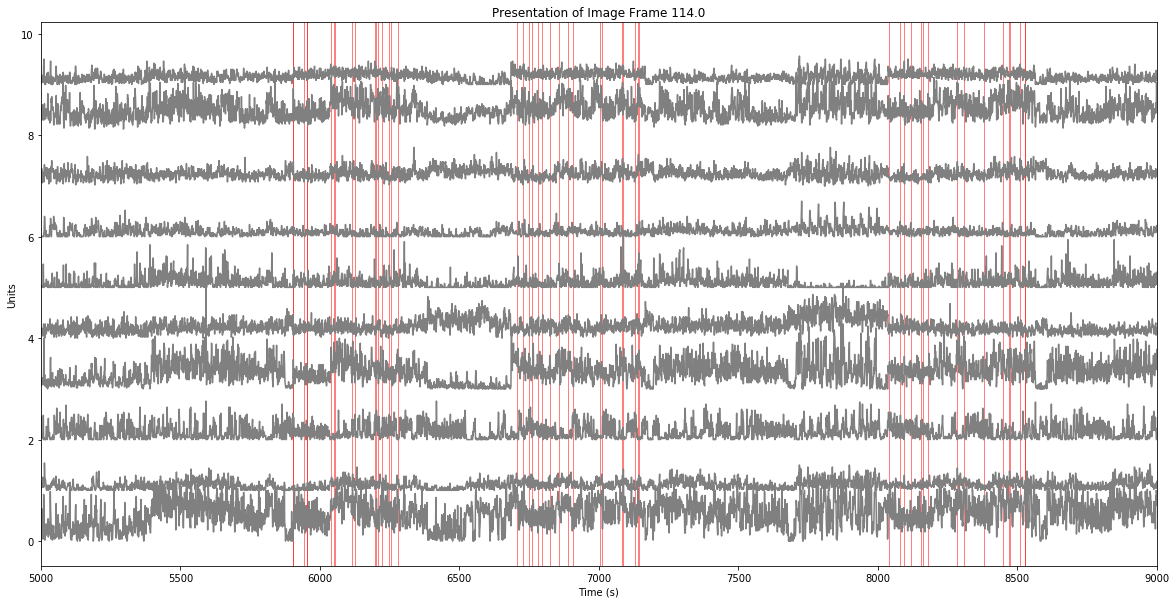

In [14]:
plt.figure(figsize=(20,10))

# Assign a dataframe that only contains presentations of our image of interest
stim_subset = natural_scenes_df[natural_scenes_df['frame']==my_image]

# Offset the firing rates and plot them
for i in range(numunits):
    plt.plot(i+(visp_binned[i,:]/50), color='gray')

# Plot the times are image of interest was presented
for j in range(len(stim_subset)):
    plt.axvspan(xmin=stim_subset['start_time'].iloc[j], xmax=stim_subset['start_time'].iloc[j], color='r', alpha=0.5)

plt.title('Presentation of Image Frame ' + str(my_image))
plt.xlabel('Time (s)')
plt.ylabel('Units')
plt.xlim(5000,9000)
plt.show()

You are not limited to only plotting the the times where a certain image was presented, nor are you limited to only plotting `natural_scenes` stimuli. You can create a similar graph with `gabors`, `flashes`, or any other availabe `stimulus_name`. For example, you can plot all the times when a `gabors` stimulus was presented at a cetain spatial frequncy, temporal frequency, or orientaion. You can use `get_stimulus_parameter_values` to return a dictionary of all parameteres used in a session. 

In [15]:
session_parameters = session.get_stimulus_parameter_values()
for key, value in session_parameters.items():
    print(key + ': ' + str(value))

color: [-1.0 1.0]
contrast: [0.8 1.0]
frame: [-1.0 0.0 1.0 ... 3597.0 3598.0 3599.0]
orientation: [0.0 30.0 45.0 60.0 90.0 120.0 135.0 150.0 180.0 225.0 270.0 315.0]
phase: ['0.0' '0.25' '0.5' '0.75' '[0.0, 0.0]' '[21211.93333333, 21211.93333333]'
 '[3644.93333333, 3644.93333333]']
size: ['[1920.0, 1080.0]' '[20.0, 20.0]' '[250.0, 250.0]' '[300.0, 300.0]']
spatial_frequency: ['0.02' '0.04' '0.08' '0.16' '0.32' '[0.0, 0.0]']
temporal_frequency: [1.0 2.0 4.0 8.0 15.0]
x_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]
y_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]


Below we will focus on the `gabors` presentations in our session and see how different orientations affected the firing rate. We will take a look at the first `gabors` presentation that was oriented 90 degrees. 

In [16]:
# Assign dataframe with only 'gabors' presentations
gabors_df = session.get_stimulus_table('gabors')

# Subselect units that were presented 90 degree orientation stimuli
subset = gabors_df[(gabors_df['orientation']==90)]

#  Assign start and end time of first 'gabors' presentation
start = subset['start_time'].iloc[0]
end = subset['stop_time'].iloc[0]

The function below was made to create a raster plot of spikes with rectangluar bars indicating when the stimulus started and ended.

In [25]:
def plot_raster(spike_times, start, end):
    
    # Assign you will plot
    num_units = len(spike_times)
    ystep = 1 / num_units
    
    # Set axis limits to include all units of interest
    ymin = 0
    ymax = ystep

    # Plot raster for spikes within the start and end times
    for unit_id, unit_spike_times in spike_times.items():
        unit_spike_times = unit_spike_times[np.logical_and(unit_spike_times >= start, unit_spike_times < end)]
        plt.vlines(unit_spike_times, ymin=ymin, ymax=ymax)

        ymin += ystep
        ymax += ystep

In [ ]:
plt.figure(figsize=(8,6))
plot_raster(all_spike_times, start-0.5, end+0.5)
plt.axvspan(start, end, color='red', alpha=0.1)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Units', fontsize=16)
plt.tick_params(axis="y", labelleft=False, left=False)
plt.show()

In [24]:
# Create 1 list containing all the times a unit fired
#spike_list = []
#for i in (all_spike_times):
#    for val in (VISp_unit_ids):
#        spikes = all_spike_times[val]
#        for j in spikes:
#            spike_list.append(j)

In [23]:
# Create 1 second bins for all spikes
#spike_array = np.array(spike_list)
#numbins = int(np.ceil(spike_array.max()))
#binned_spikes = np.empty(numbins)

# Assign the frequency of spikes over time
#for i in range(numbins):
#    binned_spikes[i] = len(spike_array[(spike_array>i)&(spike_array<i+1)])

## Running Speeds

The running speed of the mice in our session have also been recorded and are available to you. You can acess the running speed by calling `running_speed` on our `EcephysSession` object. This will return a pandas dataframe that contains the `start_time`, `end_time`, and `velocity` of our session.

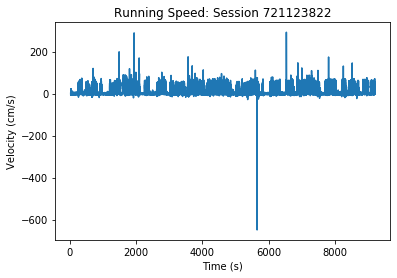

In [19]:
running_speed = session.running_speed

plt.plot(running_speed['end_time'], running_speed['velocity'])
plt.title('Running Speed: Session 721123822')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.show()

With the running speed, we can ask if their is correlation between the firing rates of our units and the velocity of our mouse. Similar to how we plotted above, we can plot the running speed of the session over the firing rates and see if increases in running speed align with more neural activity. 

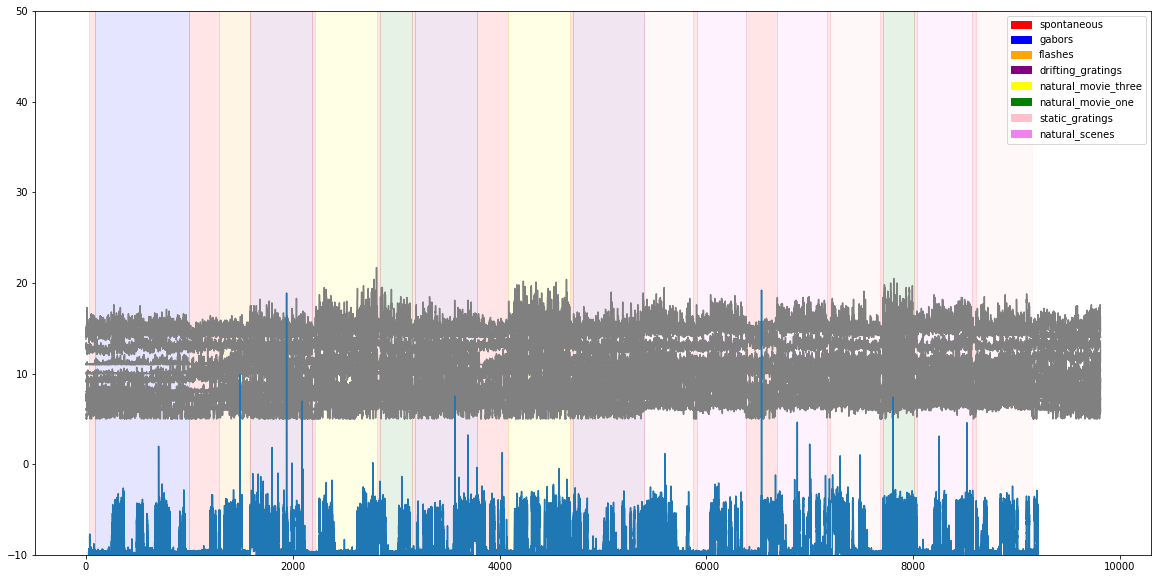

In [20]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+5+(visp_binned[i,:]/10), color='gray')

plt.plot(running_speed['end_time'], (running_speed['velocity']*0.1)-10)

for c, stim_name in enumerate(all_stims):
    stim = stim_timeblocks[stim_timeblocks['stimulus_name']==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim['start_time'].iloc[j], xmax=stim['stop_time'].iloc[j], color=colors[c], alpha=0.1)

plt.legend(handles = colors_leg)
plt.ylim(-10,50)
plt.show()

## Signal Correlations

In [15]:
spf = flashes_histogram[0]
max_len = spf.shape[0]

In [16]:
# get two spike trains in flashes activity
spike_train_1_flash=spf[:max_len, 0]
spike_train_2_flash=spf[:max_len, 9]

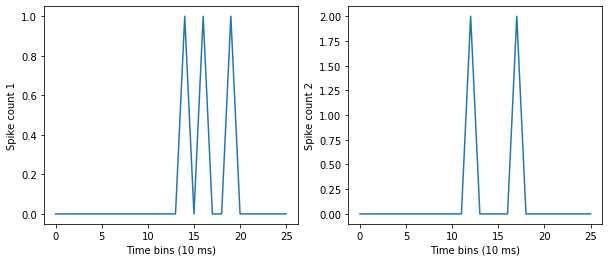

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(10,4))

ax[0].plot(spike_train_1_flash)
ax[0].set_ylabel('Spike count 1')
ax[0].set_xlabel('Time bins (10 ms)')

ax[1].plot(spike_train_2_flash)
ax[1].set_ylabel('Spike count 2')
ax[1].set_xlabel('Time bins (10 ms)')
plt.show()

In [18]:
# compute the correlogram for spontaneous activity
xcorr_flashes = sp.signal.correlate(spike_train_1_flash,spike_train_2_flash)

# time steps
time_shift_flashes = np.arange(-len(xcorr_flashes)/2,len(xcorr_flashes)/2,1)

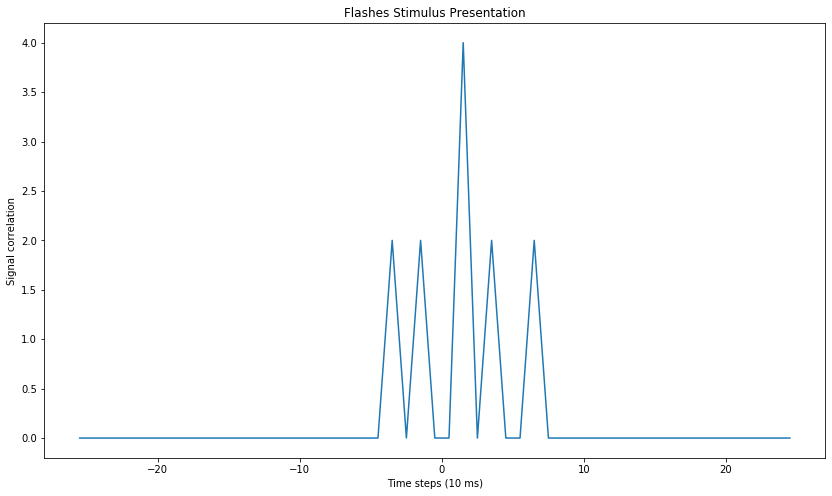

In [19]:
plt.figure(figsize=(14,8))
plt.plot(time_shift_flashes,xcorr_flashes)
plt.ylabel('Signal correlation')
plt.xlabel('Time steps (10 ms)')
plt.title('Flashes Stimulus Presentation')
plt.show()

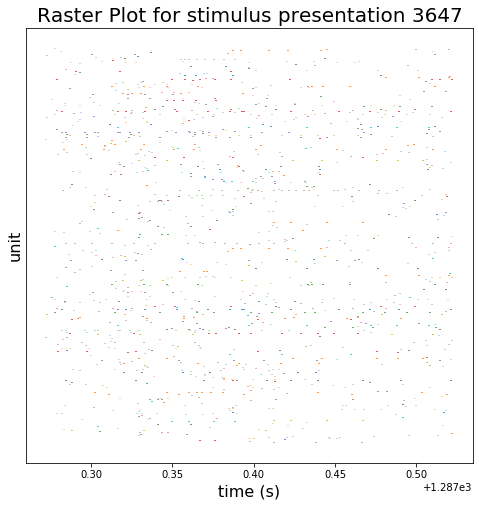

Parameters for presentation 3647


color                               1.0
contrast                            0.8
frame                              null
orientation                         0.0
phase                        [0.0, 0.0]
size                     [300.0, 300.0]
spatial_frequency            [0.0, 0.0]
start_time                  1287.272022
stimulus_block                      1.0
stimulus_name                   flashes
stop_time                   1287.522219
temporal_frequency                 null
x_position                         null
y_position                         null
duration                       0.250197
stimulus_condition_id               244
Name: 3647, dtype: object

In [25]:
# Return presentation ids from stimulus presentation dataframe for 'flashes' stimulus
flashes_presentation_ids = stim_pres.loc[(stim_pres['stimulus_name'] == 'flashes')].index.values


times = session.presentationwise_spike_times(
    stimulus_presentation_ids=flashes_presentation_ids,
    unit_ids= None)

# Assign the stimulus presentation id
first_flashes_presentation_id = times['stimulus_presentation_id'].values[0]

# Assign recording times for 'flashes' stimulus presentations
plot_times = times[times['stimulus_presentation_id'] == first_flashes_presentation_id]

# Assign Raster plot 
ecvis.raster_plot(plot_times, title = 'Raster Plot for stimulus presentation 3647')

plt.show()

print('Parameters for presentation 3647')
stim_pres.loc[first_flashes_presentation_id]

In [26]:
spike_statistics = session.conditionwise_spike_statistics(stimulus_presentation_ids = flashes_presentation_ids,
                                                          unit_ids = None)

spike_statistics.head()

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,stimulus_condition_id,,,,,
950907205,244,253,75,3.373333,1.991694,0.229981
950907216,244,123,75,1.640000,1.401158,0.161792
950907220,244,1000,75,13.333333,4.647968,0.536701
950907222,244,9,75,0.120000,0.366134,0.042278
950907225,244,112,75,1.493333,1.234343,0.142530
